In [2]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from pathlib import Path
from torch.utils.data import DataLoader, Dataset, random_split
from google.colab import drive
import librosa.display as dis
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'torchaudio'

In [1]:
drive.mount('/content/drive')

NameError: name 'drive' is not defined

Preprocessing

In [ ]:
class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
  

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))


  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))


  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  
  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [ ]:
test_path = '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/Sound_Data/Gunshots_From_Different_Angles_two/glock_oneshot1.wav'
Audio(filename=test_path)

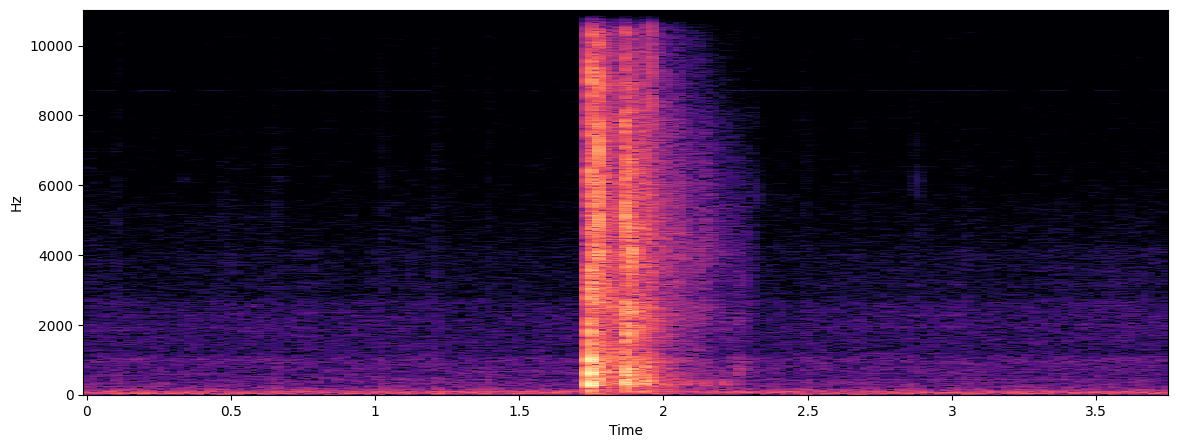

In [ ]:
def view_spectogram(file_path):
  x, sr = librosa.load(file_path)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(14, 5))
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

view_spectogram(test_path)

In [ ]:
def create_mel_spectogram_train(file_path,name):
  x, sr = librosa.load(file_path)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(14, 5))
  X_mag, _ = librosa.magphase(X)
  mel_scale_sgram = librosa.feature.melspectrogram(S=X_mag, sr=sr)
  librosa.display.specshow(mel_scale_sgram)
  filename  = Path('/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/train/' + name + '.jpg')
  plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
  plt.close()    
  plt.close('all')

  #Calling this on a filepath with save the image to train

In [ ]:
def create_mel_spectogram_test(file_path,name):
  x, sr = librosa.load(file_path)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(14, 5))
  X_mag, _ = librosa.magphase(X)
  mel_scale_sgram = librosa.feature.melspectrogram(S=X_mag, sr=sr)
  librosa.display.specshow(mel_scale_sgram)
  filename  = Path('/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/test/' + name + '.jpg')
  plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
  plt.close()    
  plt.close('all')

  #Calling this on a filepath with save the image to train

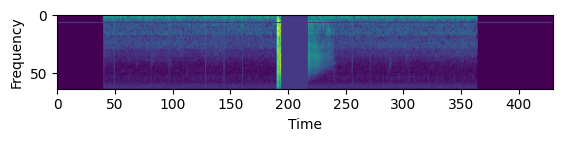

In [ ]:
import numpy as np
def preprocess(file_name, sampling_rate, max_ms):
  sig, sr = AudioUtil.open(file_name)
  ((resig, sr)) = AudioUtil.rechannel((sig,sr), 2)
  ((resig, newsr)) = AudioUtil.resample((resig, sr), sampling_rate) #standardise to a sampling rate of this
  (sig, sr) = AudioUtil.pad_trunc((resig,newsr), max_ms)
  (item, sr) = AudioUtil.time_shift((sig,sr), 0.2) #shift limit set to 0.2 by default, data augment
  spectogram = AudioUtil.spectro_gram((item,sr))
  augspec = AudioUtil.spectro_augment(spectogram)

  return augspec

def viewspec(spec):
  spec = np.array(spec)
  spec = np.transpose(spec, (1, 2, 0))
  spec = np.mean(spec, axis=2)
  plt.imshow(spec)
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.show()

spec = preprocess(test_path, 44100, 5000)
viewspec(spec)

Fetching Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
gunshots_csv_path = '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/Sound_Data/Gunshots_From_Different_Angles_FULL/edge-collected-gunshot-audio/gunshot-audio-labels-only.csv'
gunshot_files_path = '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/Sound_Data/Gunshots_From_Different_Angles_FULL/edge-collected-gunshot-audio/edge-collected-gunshot-audio/gunshots'

In [ ]:
gunshots = pd.read_csv(gunshots_csv_path)
gunshots = gunshots[gunshots[' num_gunshots'] == 1]
gunshots = gunshots[['filename', ' num_gunshots', ' gunshot_location (in seconds)']]
gunshots.head()

,filename,num_gunshots,gunshot_location (in seconds)
1,019439aa-e146-49da-b59c-28a594fba7e2_v1,1,1.720635
7,019439aa-e146-49da-b59c-28a594fba7e2_v7,1,1.750000
14,022dd50f-a4ee-4b33-b267-8df6e4e40f20_v6,1,1.750000
15,022dd50f-a4ee-4b33-b267-8df6e4e40f20_v7,1,1.750000
26,0495b86d-2f39-4912-916b-0cfbc160cf3d_chan0_v1,1,1.750000


In [ ]:
non_gunshots_csv_path = '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/Sound_Data/Plastic_Bag_Pop/plasticbagpop_metadata.csv'
non_gunshots_files_path = '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/Sound_Data/Plastic_Bag_Pop/NoClip'

In [ ]:
non_gunshots = pd.read_csv(non_gunshots_csv_path)
non_gunshots.head()

,slice_file_name,fsID,fold,classID,class_name
0,100001010800.wav,NaN,NaN,11,plastic_bag
1,100001020500.wav,NaN,NaN,11,plastic_bag
2,100001020800.wav,NaN,NaN,11,plastic_bag
3,1000010220400.wav,NaN,NaN,11,plastic_bag
4,100001050800.wav,NaN,NaN,11,plastic_bag


In [ ]:
#https://www.kaggle.com/datasets/chrisfilo/urbansound8k?resource=download

Converting Sounds to JPG (some code is in create_mel_spectogram function )

1.   Create train dir
2.   Create test dir



In [ ]:
!mkdir '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/test'
!mkdir '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/train'

mkdir: cannot create directory ‘/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/test’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/train’: File exists


In [ ]:
Data_dir=np.array(glob("/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/Sound_Data/Plastic_Bag_Pop/NoClip/*"))
#Data_dir of all the filepaths for the plastic bag pop sounds

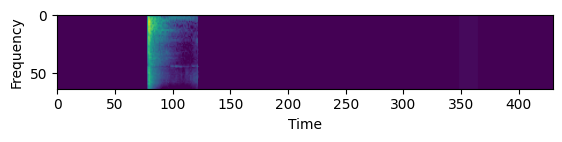

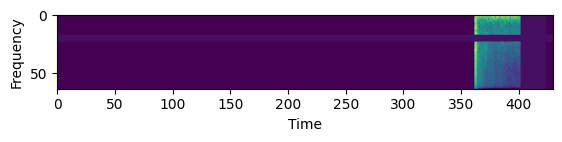

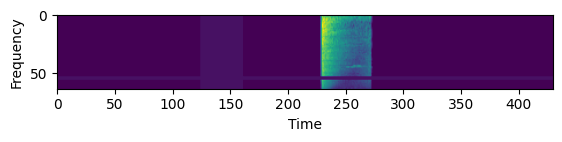

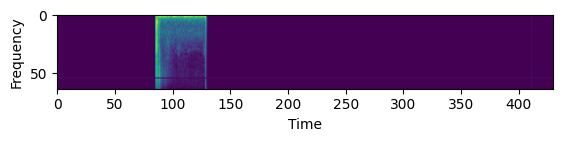

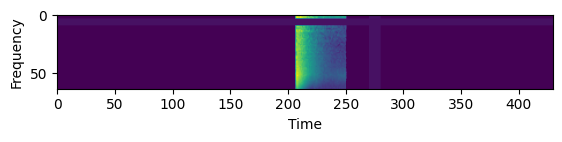

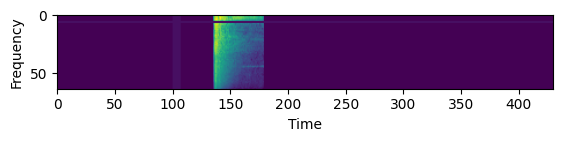

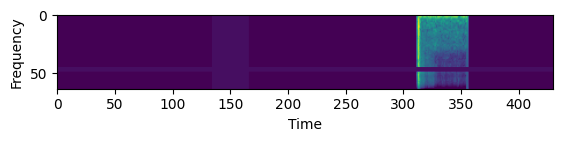

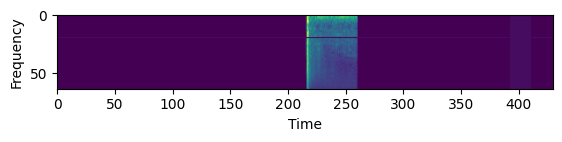

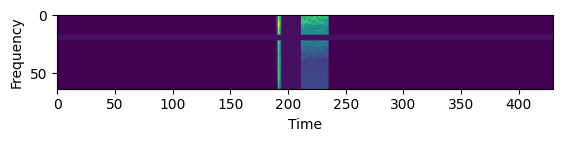

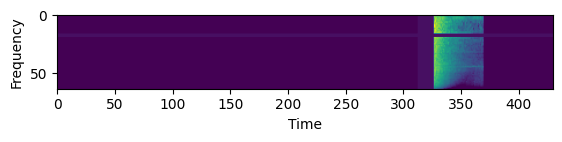

In [ ]:
'''
#WILL NEED TO DELETE THIS, JUST KEEPING HERE FOR WHICH WE WANT TO USE
#WE MAY NEED TO JUST USE LIBROSAS BUILT IN CREATE_MEL_SPECTROGRAM
i=0
count = 10
for file in Data_dir[i:i+count]:
    spec = preprocess(file,44100,5000)
    viewspec(spec)
    #with datapreprocessing
'''

In [ ]:
train_filenames = []
test_filenames = []

In [ ]:
i=0
count = 500
for file in Data_dir[i:i+count]:
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_mel_spectogram_train(filename,name)
    train_filenames.append(name)
  
for file in Data_dir[i+count:]:
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_mel_spectogram_test(filename,name)
    test_filenames.append(name)

#What this does is convert 500 plastic bag sounds to jpg and puts it in the train folder and the 100 rest go into test, we also view it below
#Without datapreprocessing, in train folder

In [ ]:
gc.collect() #garbage collection?

1300610

KeyboardInterrupt: ignored

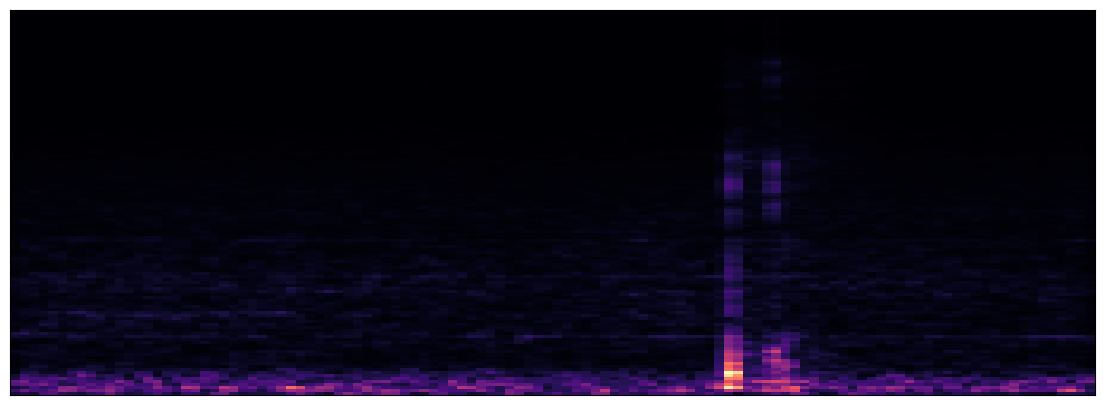

In [ ]:
i=0
length = len(gunshots['filename'])
count = length/3 * 2
for file in gunshots['filename']:
  if (i <= count):
    i+=1
    filename,name = '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/Sound_Data/Gunshots_From_Different_Angles_FULL/edge-collected-gunshot-audio/edge-collected-gunshot-audio/gunshots/'+file+'.wav',file.split('/')[-1].split('.')[0]
    try:
      create_mel_spectogram_train(filename,name)
      # train_filenames.append(name)
    except (FileNotFoundError, IOError):
        print("file not found:", filename)
        continue
  else:
    i+=1
    filename,name = '/content/drive/MyDrive/Tensegrity Gunshot Detection/Detection_Model/Sound_Data/Gunshots_From_Different_Angles_FULL/edge-collected-gunshot-audio/edge-collected-gunshot-audio/gunshots/'+file+'.wav',file.split('/')[-1].split('.')[0]
    
    try:
      create_mel_spectogram_test(filename,name)
      # test_filenames.append(name)
    except (FileNotFoundError, IOError):
        print("file not found:", filename)
        continue
    
  
    

#What this does is converts 2/3 of the gunshot sounds to jpg and puts it in the train folder, we also view it below
#Without datapreprocessing, in train folder

#NEED TO ADD A TRY CATCH, it seems some files in the CSV are not given to us


In [ ]:
i=0
length = len(gunshots['filename'])
count = length/3 * 2
for file in gunshots['filename']:
  if (i <= count):
    train_filenames.append(file.split('/')[-1].split('.')[0])   
    i+=1
  else:
    test_filenames.append(file.split('/')[-1].split('.')[0])
    i+=1

019439aa-e146-49da-b59c-28a594fba7e2_v1
019439aa-e146-49da-b59c-28a594fba7e2_v7
022dd50f-a4ee-4b33-b267-8df6e4e40f20_v6
022dd50f-a4ee-4b33-b267-8df6e4e40f20_v7
0495b86d-2f39-4912-916b-0cfbc160cf3d_chan0_v1
0495b86d-2f39-4912-916b-0cfbc160cf3d_chan1_v1
0495b86d-2f39-4912-916b-0cfbc160cf3d_chan2_v1
0495b86d-2f39-4912-916b-0cfbc160cf3d_chan3_v1
0495b86d-2f39-4912-916b-0cfbc160cf3d_chan4_v1
0495b86d-2f39-4912-916b-0cfbc160cf3d_chan5_v1
0495b86d-2f39-4912-916b-0cfbc160cf3d_chan6_v1
0495b86d-2f39-4912-916b-0cfbc160cf3d_mean_v1
04d81d9d-63e9-46b1-9417-6fe40765be9a_chan0_v0
04d81d9d-63e9-46b1-9417-6fe40765be9a_chan1_v0
04d81d9d-63e9-46b1-9417-6fe40765be9a_chan2_v0
04d81d9d-63e9-46b1-9417-6fe40765be9a_chan4_v0
04d81d9d-63e9-46b1-9417-6fe40765be9a_chan5_v0
04d81d9d-63e9-46b1-9417-6fe40765be9a_mean_v0
04f1be04-da3e-4f7d-b4fc-6b64f208cc94_v0
04f1be04-da3e-4f7d-b4fc-6b64f208cc94_v1
04f1be04-da3e-4f7d-b4fc-6b64f208cc94_v2
04f1be04-da3e-4f7d-b4fc-6b64f208cc94_v3
04f1be04-da3e-4f7d-b4fc-6b64f208cc94_v

Creating Label DF

In [5]:
# only run once
gunshots = gunshots.drop(columns=[' num_gunshots', ' gunshot_location (in seconds)'])

NameError: ignored

In [ ]:
gunshots['label'] = 'gunshot'
gunshots.head()

,filename,label
1,019439aa-e146-49da-b59c-28a594fba7e2_v1,gunshot
7,019439aa-e146-49da-b59c-28a594fba7e2_v7,gunshot
14,022dd50f-a4ee-4b33-b267-8df6e4e40f20_v6,gunshot
15,022dd50f-a4ee-4b33-b267-8df6e4e40f20_v7,gunshot
26,0495b86d-2f39-4912-916b-0cfbc160cf3d_chan0_v1,gunshot


In [ ]:
# only run once
non_gunshots = non_gunshots.drop(columns = ['fsID', 'fold', 'classID'])
non_gunshots = non_gunshots.rename(columns = {'slice_file_name': 'filename', 'class_name': 'label'})

KeyError: ignored

In [ ]:
non_gunshots['filename'] = non_gunshots['filename'].map(lambda x : x.split('.')[0])
non_gunshots.head()

,filename,label
0,100001010800,plastic_bag
1,100001020500,plastic_bag
2,100001020800,plastic_bag
3,1000010220400,plastic_bag
4,100001050800,plastic_bag


In [ ]:
train_filenames = [x.split('/')[-1] for x in train_filenames]
test_filenames = [x.split('/')[-1] for x in test_filenames]

In [ ]:
print(train_filenames)

['10005030500', '1500070120400', '150005020500', '100007020800', '2000020220400', '1000050120400', '10007040500', '1000070320400', '200007030500', '150005040500', '150001040800', '100005040500', '1500040620400', '150007070800', '100007060500', '1500070420400', '100007040500', '100001010800', '1000010640000', '150007060800', '1500040420400', '200005050500', '150001020800', '2000040240000', '100040240000', '100002020800', '150007040800', '1000050220400', '150002030800', '2000020240000', '100001050800', '200007020800', '2000040140000', '1500070640000', '100020640000', '1500050420400', '1000070440000', '150007050800', '1000020240000', '150001060500', '1500010640000', '1000040120400', '100010620400', '1500050220400', '100040640000', '10003010500', '2000040220400', '200003010500', '150002050500', '100007010800', '1500040220400', '200003020500', '100007020500', '10007050500', '1500050120400', '100070620400', '100070220400', '10007060500', '150002060800', '200005020500', '200005060500', '15000

In [ ]:
labels = pd.concat([non_gunshots, gunshots])
labels_train = labels[labels['filename'].isin(train_filenames)]
labels_test = labels[labels['filename'].isin(test_filenames)]

In [ ]:
labels.head(-100)

,filename,label
0,100001010800,plastic_bag
1,100001020500,plastic_bag
2,100001020800,plastic_bag
3,1000010220400,plastic_bag
4,100001050800,plastic_bag
...,...,...
1917,df9c8055-a6c4-483e-ac29-6da128a2cb18_v5,gunshot
1936,e2f3a120-6fcd-4760-917d-bb03ebff63d8_chan0_v0,gunshot
1937,e2f3a120-6fcd-4760-917d-bb03ebff63d8_chan0_v1,gunshot
1938,e2f3a120-6fcd-4760-917d-bb03ebff63d8_chan0_v2,gunshot


In [ ]:
labels_train.head(-100)

,filename,label
0,100001010800,plastic_bag
1,100001020500,plastic_bag
2,100001020800,plastic_bag
3,1000010220400,plastic_bag
4,100001050800,plastic_bag
...,...,...
1262,972e5199-b99c-4f49-b006-ec7c2903f2ee_chan6_v0,gunshot
1264,972e5199-b99c-4f49-b006-ec7c2903f2ee_mean_v0,gunshot
1269,982a287d-e590-4f32-bb52-293f837e30df_v0,gunshot
1282,9b5c4fdb-b0ee-447d-ae1b-1d4576660a4e_v0,gunshot


In [ ]:
labels_test.head(-100)

,filename,label
0,100001010800,plastic_bag
1,100001020500,plastic_bag
2,100001020800,plastic_bag
3,1000010220400,plastic_bag
4,100001050800,plastic_bag
...,...,...
1262,972e5199-b99c-4f49-b006-ec7c2903f2ee_chan6_v0,gunshot
1264,972e5199-b99c-4f49-b006-ec7c2903f2ee_mean_v0,gunshot
1269,982a287d-e590-4f32-bb52-293f837e30df_v0,gunshot
1282,9b5c4fdb-b0ee-447d-ae1b-1d4576660a4e_v0,gunshot


In [8]:
%pip install fastai==1.0.58

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached fastai-1.0.58-py3-none-any.whl (236 kB)
  Using cached torch-2.0.0-cp39-none-macosx_10_9_x86_64.whl (139.8 MB)
  Using cached nvidia-ml-py3-7.352.0.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached torchvision-0.15.1-cp39-cp39-macosx_10_9_x86_64.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 6.0 MB/s eta 0:00:00
  Using cached matplotlib-3.7.1-cp39-cp39-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached pynvx-1.0.0-cp39-cp39-macosx_10_9_x86_64.whl (119 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 4.1 MB/s eta 0:00:00
  Using cached spacy-3.5.1-cp39-cp39-macosx_10_9_x86_64.whl

In [1]:
from fastai import *
from fastai.vision import *
import pylab
import matplotlib
import gc
from glob import glob
import pandas as pd
import numpy as np

In [2]:
from fastai.vision.data import ImageDataBunch

path = Path('/Users/shaamerk/Desktop/class/Squishy Robotics/gunshot/noisedetection')
np.random.seed(42)
train_df = pd.read_csv('/Users/shaamerk/Desktop/class/Squishy Robotics/gunshot/noisedetection/train_labels.csv', index_col=0)
data = ImageDataBunch.from_df(path = path, df = train_df, folder = 'all', valid_pct=0.2, suffix='.jpg', num_workers=0)

In [3]:
data.classes

['Gunshot', 'Non_Gunshot']

In [4]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)

/usr/local/lib/python3.9/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/shaamerk/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

In [5]:
learn.fit_one_cycle(4)

: 

: 

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

In [ ]:
learn.save('stage-2')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(1e-6,2e-6))

In [ ]:
learn.save('stage-3')

Making Predictions

In [ ]:
with open('output.csv',"w") as file:
    file.write("ID,Prediction\n")
    for file in labels_test.filename:
        img = open_image('test/'+str(file)+'.jpg')
        prediction = str(learn.predict(img)[0]).split()[0]
        file.write(str(file)+','+prediction)
        file.write('\n')

In [ ]:
output = pd.read_csv('output.csv')
output.head()

Cleanup

In [ ]:
'''
%%capture
!apt-get install zip
!zip -r train.zip /kaggle/working/train/
!zip -r test.zip /kaggle/working/test/
!rm -rf train/*
!rm -rf test/*
'''